### `Gather` Tutorial

This tutorial introduces reader to `Gather` class, a simple object that stores seismic gather data and provides an interface for its processing. <br>
The notebook demonstrates how to create `Gather` instance, its most useful attributes and seismic processing methods.

### Content

[Introduction](#Introduction) <br>
[Creating Gather](#Creating-Gather) <br>
[Attributes](#Attributes) <br>
[General Methods](#General-Methods)<br>
[Normalization Methods](#Normalization-Methods) <br>
[Muting Methods](#Muting-Methods) <br>
[Conclusion](#Conclusion) <br>

In [ ]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from seismicpro import Survey, Muter, make_prestack_segy
from utils import generate_trace

### Introduction

`Survey` is a concise representation of SEG-Y file: while it stores specified seismic headers, it does not load any seismic data to keep memory footprint to a minimum. Instead, it provides a way to process seismic data gather-wise, which is very convenient when working with Machine Learning tasks. <br>
To work with trace data, one needs to use `Gather` class: it contains a subset of `Survey`'s headers selected by common `header_index` value and the corresponding seismic traces.

Example scheme below demonstrates which information from SEG-Y files is stored in instances of `Survey` and `Gather` classes. <br>
Here an instance of `Survey` is created with `'FieldRecord'` as `header_index` and `['TraceNumber', 'offset', 'CDP']` as `header_cols`: <br>
```python
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset', 'CDP'])
```
A `Gather` instance created with the following line
```python
gather = survey.get_gather(912)
```
will contain a subset of its parent survey header and seismic traces that share common value of `FieldRecord` equal to 912.

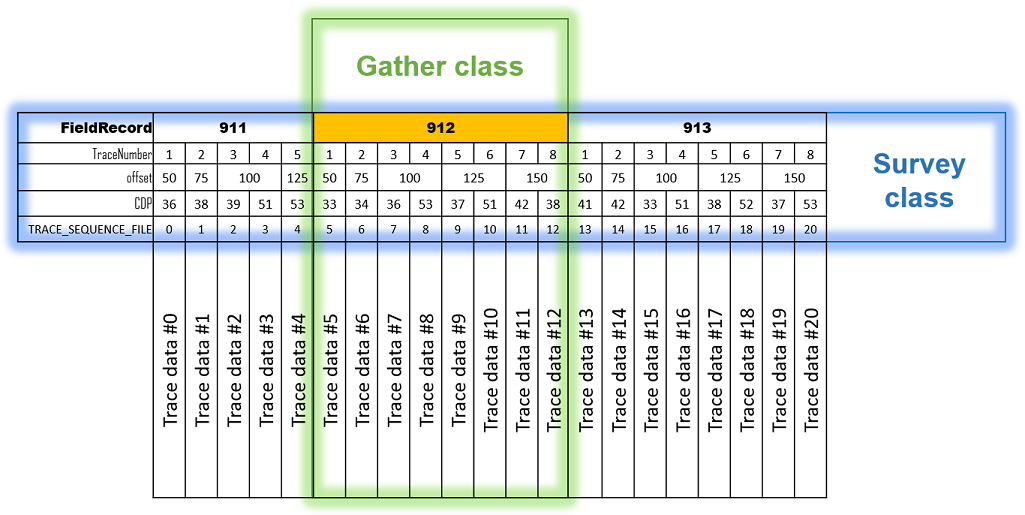

### Creating Gather

For convenience, this tutorial uses SEG-Y file with synthetic data that is going to be generated in the following cell.

In [2]:
sgy_path = './synthetic_survey.sgy'
make_prestack_segy(sgy_path, survey_size=(1500,1500), activation_dist=(1500,1500), trace_gen=generate_trace)

  0%|          | 0/150 [00:00<?, ?it/s]

To learn more about `Survey` class, see [Survey tutorial](./1_Survey_tutorial.ipynb).

In [3]:
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset'], collect_stats=True)

Calculating statistics for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

`Survey` provides two methods to generate `Gather` instances: `Survey.get_gather()` and `Survey.sample_gather()`.

<b> `get_gather()`</b>

To create `Gather` instance using `get_gather()` method one needs to provide `header_index`'s value, which will be used to load corresponding traces from SEG-Y file and make a subset of `Survey.headers` dataframe. <br>

In [4]:
survey.headers

,TraceNumber,offset,TRACE_SEQUENCE_FILE
FieldRecord,,,
0,0,0,1
0,1,25,2
0,2,50,3
0,3,75,4
0,4,100,5
...,...,...,...
149,895,182,134996
149,896,206,134997
149,897,230,134998


Different values from <b>FieldRecord</b> column will result in different common shot gathers.

In [5]:
gather = survey.get_gather(index=0)

Now take a look at the information about resulting `gather` instance using its `info()` method:

In [6]:
gather.info()


Parent survey path:          ./synthetic_survey.sgy
Parent survey name:          synthetic_survey

Number of traces:            900
Trace length:                1500 samples
Sample rate:                 2.0 ms
Times range:                 [0.0 ms, 2998.0 ms]
Offsets range:               [0 m, 2033 m]

Index name(s):               FieldRecord
Index value:                 0
Gather sorting:              None

Gather statistics:
Number of dead traces:       0
mean | std:                        0.01 | 0.62      
 min | max:                       -7.53 | 5.47      
 q01 | q99:                       -1.58 | 1.90      



<b> Note: </b>
In case Gather is created from the Survey with limits, traces will be loaded within specified time limits.

<b>`sample_gather()`</b>

`sample_gather()` creates `Gather` instance same as `get_gather()`, but it randomly selects an index value from `header_index`:

```python
gather = survey.sample_gather()
```

### Attributes

Let discuss useful attributes of the Gather class.

<b>`headers`</b> - `pandas.Dataframe` containing the subset of the parent `Survey`'s headers with index value specified at gather instantiation.

In [7]:
gather.headers

,TraceNumber,offset,TRACE_SEQUENCE_FILE
FieldRecord,,,
0,0,0,1
0,1,25,2
0,2,50,3
0,3,75,4
0,4,100,5
...,...,...,...
0,895,1962,896
0,896,1979,897
0,897,1997,898


<b>`data`</b> - `numpy.array` containing the `Gather`'s trace data.

In [8]:
gather.data

array([[-1.1794828 , -1.4285158 , -1.6131808 , ...,  1.9078306 ,
         1.4524662 ,  0.8683291 ],
       [-0.9366992 , -1.2785286 , -1.645276  , ...,  0.7155079 ,
         0.5832989 ,  0.40761465],
       [-0.05444511, -0.1005611 , -0.17726174, ...,  0.63515836,
         0.6155854 ,  0.5148447 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.46681565,
         0.65791345,  0.74503314],
       [ 0.        ,  0.        ,  0.        , ...,  1.3039951 ,
         1.100782  ,  0.7953944 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.3369778 ,
         1.2843976 ,  1.104035  ]], dtype=float32)

The shape of the `data` array is (`Number of traces in gather`, `Trace length in samples`):

In [9]:
gather.data.shape

(900, 1500)

<b>`samples`</b> - an array of record timestamps in milliseconds.

In [10]:
gather.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03], dtype=float32)

<b>`sample_rate` </b> - sample interval for each trace in milliseconds.

In [11]:
gather.sample_rate

2.0

### General Methods

**Note** that most of the methods described here and in the following sections work inplace.

<b>`plot()`</b>

`plot()` method shows gather's seismic data.

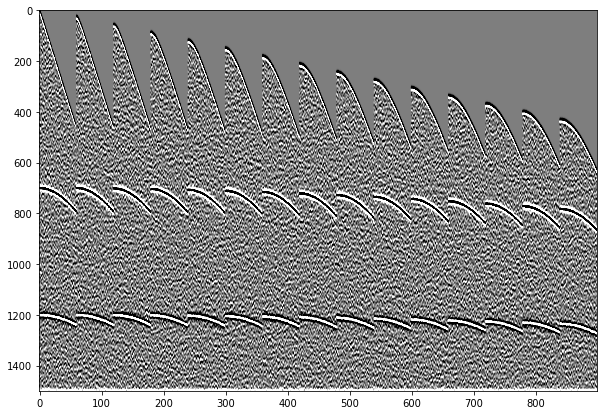

In [12]:
gather.plot()

Plotted seismogram looks like this because traces are sorted by 'TraceNumber'.

The Y-axis of the plot corresponds to samples and the X-axis to trace numbers. <br>
`plot()` uses `'gray'` colormap by default, where white and black colors represent high and low values respectively.

<b>`sort()` </b>

Sort traces in gather by the specified `header_cols` value.<br>
Only sorts in ascending order.

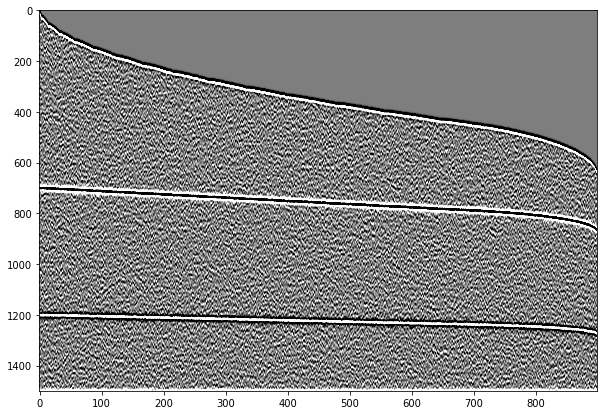

In [13]:
gather.sort(by='offset')
gather.plot()

`sort_by` attribute of the gather shows current sorting:

In [14]:
gather.sort_by

'offset'

<b>`copy()`</b>

Makes a copy of `Gather` instance.

As was mentioned before most of the `Gather`'s methods change its data inplace. Using `copy()` allows working with the copy of gather while the original one is left unchanged.

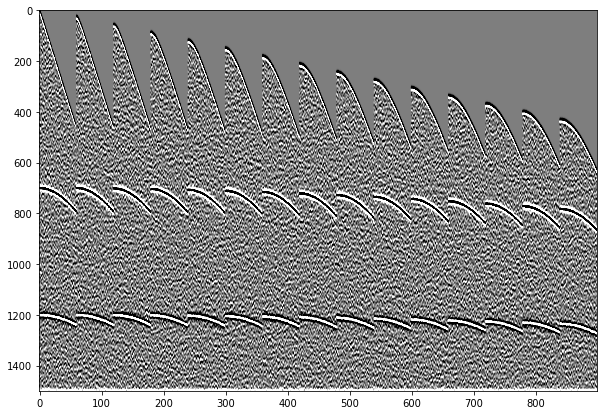

In [15]:
gather_copy = gather.copy()
gather_copy.sort(by='TraceNumber')
gather_copy.plot()

While sorting of `gather_copy` has changed back to `TraceNumber`, original `gather` still has `offset` sorting:

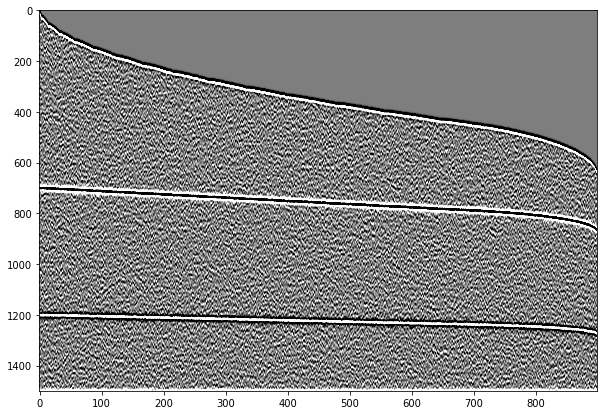

In [16]:
gather.plot()

<b>`dump()` </b>

Writes trace data and headers from a gather into a SEG-Y file. <br>

In [17]:
gather.dump(path='./data/', name='test_gather')

`path` and `name` parameters correspond to directory and name of the resulting SEG-Y file respectively.

By default, only headers from `gather.headers` are saved to the file. To include other headers from parent SEG-Y file one can add parameters `copy_header=True`:<br>
```python
gather.dump(path='./data/', name='test_gather', copy_header=True)
```

### Normalization Methods

Normalization methods transform `Gather`'s data by shifting and scaling. These transformations are useful to prepare the data for ML model training.

Behavior of all normalization methods depend on the combination of `tracewise` and `use_global` flags:
1. `tracewise=True, use_global=False`, default <br>
In this case normalization parameters are calculated for each trace independently.

2. `tracewise=False, use_global=False`<br>
The normalization parameters are calculated using all the trace data in the gather.

3. `use_global=True`<br>
In this case `tracewise` flag is ignored and normalization methods will use statistics calculated by the parent `Survey` instance.

<b>`scale_standard()` </b>

Normalize gather data by shifting the data to zero mean to and unit variance.

In [18]:
import numpy as np

In [19]:
gather_scaled = gather.copy()
gather_scaled.scale_standard()

print(f'Raw gather first trace mean: {gather.data[0].mean():.2f}, std: {gather.data[0].std():.2f}')
print(f'Scaled gather first trace mean: {gather_scaled.data[0].mean():.2f}, std: {gather_scaled.data[0].std():.2f}')

Raw gather first trace mean: 0.01, std: 0.71
Scaled gather first trace mean: 0.00, std: 1.00


If `use_global` parameter is set to `True`, normalization methods will use statistics from parent `Survey` instance. It is important to note that one needs to collect survey statistics first, for example, by calling `Survey`'s `collect_stats()` method.

In [20]:
gather_scaled = gather.copy()
gather_scaled.scale_standard(use_global=True)

print(f'Survey data mean: {survey.mean:.2f}, std: {survey.std:.2f}')
print(f'Scaled gather first trace mean: {gather_scaled.data[0].mean():.2f}, std: {gather_scaled.data[0].std():.2f}')

Survey data mean: 0.01, std: 0.63
Scaled gather first trace mean: 0.01, std: 1.13


Since survey's mean and standard deviation differ from the trace's statistics, it is essential that the scaled trace may not have zero mean and unit variance.

<b>`scale_maxabs()` </b>

Scale gather data by maximum absolute value. In this example, `tracewise` flag is set to `False`, so that scaling is performed over whole gather.

In [21]:
gather_scaled = gather.copy()
gather_scaled.scale_maxabs(tracewise=False)

print(f'Absolute minimum of the scaled gather: {gather_scaled.data.min():.2f}')
print(f'Absolute maximum of the scaled gather: {gather_scaled.data.max():.2f}')

Absolute minimum of the scaled gather: -1.00
Absolute maximum of the scaled gather: 0.73


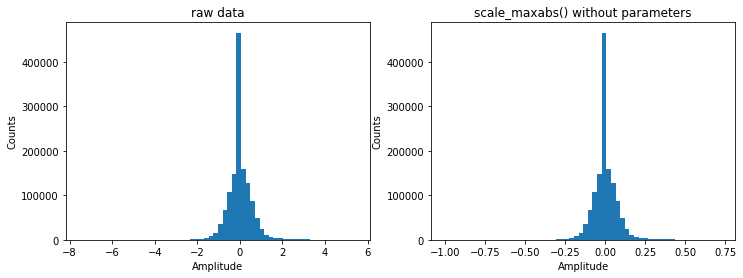

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
gather.plot('hist', ax=ax1)
gather_scaled.plot('hist', ax=ax2)
# plot_histogram(([gather, 'raw data'], [gather_scaled, 'scale_maxabs() without parameters']))

Outliers in data strongly affect the results of `scale_maxabs()` normalization, and most data points gather around zero. <br>
To deal with this problem, one can use `q_min` and `q_max` parameters, which will be used as minimum and maximum values instead of absolute minimum and maximum. 

In [23]:
gather_scaled_quantile = gather.copy()
_ = gather_scaled_quantile.scale_maxabs(q_min=0.01, q_max=0.99, tracewise=False)

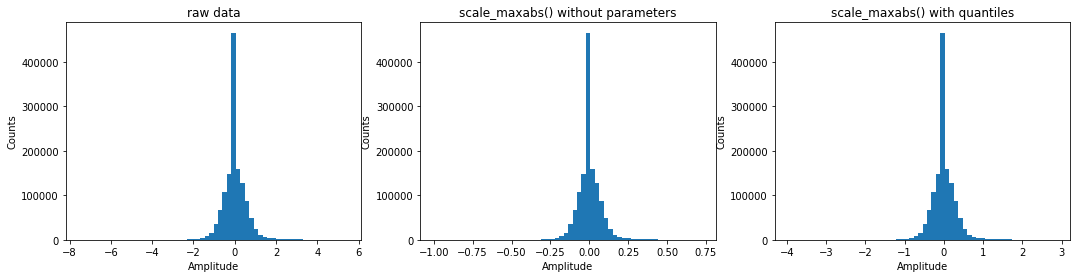

In [24]:
plot_histogram(([gather, 'raw data'],
                [gather_scaled, 'scale_maxabs() without parameters'],
                [gather_scaled_quantile, 'scale_maxabs() with quantiles']))

Data distribution around zero should be better now, but the outliers still remain. To fix this, one can use `clip` flag, which clips values outside of the [-1, 1] interval to the interval edges.<br>

In [25]:
gather_scaled_clip = gather.copy()
_ = gather_scaled_clip.scale_maxabs(q_min=0.01, q_max=0.99, clip=True, tracewise=False)

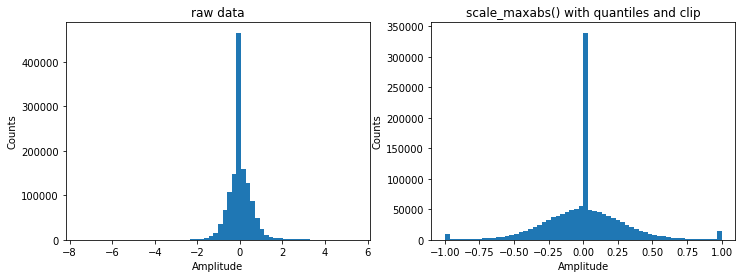

In [26]:
plot_histogram(([gather, 'raw data'], [gather_scaled_clip, 'scale_maxabs() with quantiles and clip']))

<b>`scale_minmax()` </b>

Shift and scale trace data to a [0, 1] interval.

In [27]:
gather_scaled = gather.copy()
_ = gather_scaled.scale_minmax()

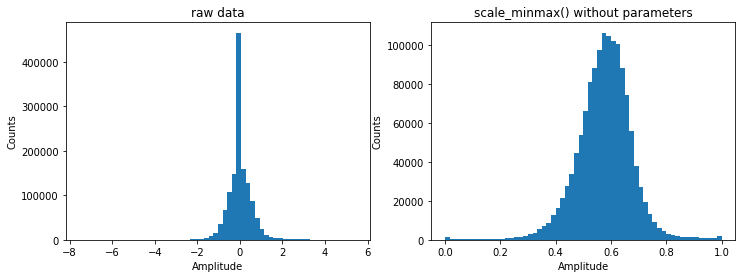

In [28]:
plot_histogram(([gather, 'raw data'], [gather_scaled, 'scale_minmax() without parameters']))

`scale_minmax()` also supports usage of quantiles and clipping, but clipping interval is [0, 1] for minmax scaler. 

In [29]:
gather_scaled_quantile = gather.copy()
_ = gather_scaled_quantile.scale_minmax(q_min=0.02, q_max=0.98)

In [30]:
gather_scaled_clip = gather.copy()
_ = gather_scaled_clip.scale_minmax(q_min=0.02, q_max=0.98, clip=True)

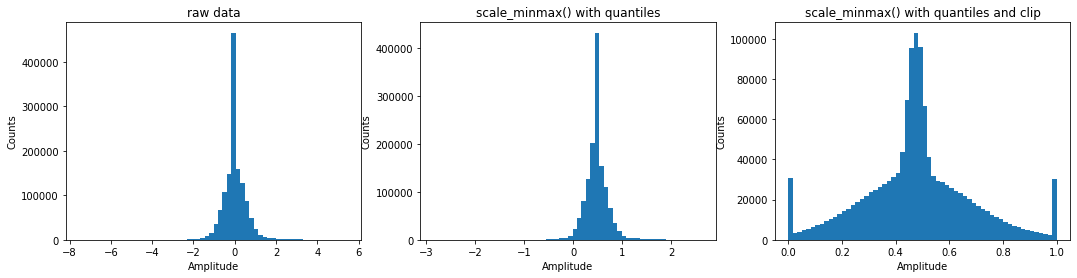

In [31]:
gather_list = ([gather, 'raw data'],
               [gather_scaled_quantile, 'scale_minmax() with quantiles'],
               [gather_scaled_clip, 'scale_minmax() with quantiles and clip'])

plot_histogram(gather_list)

### Muting Methods

Muting is a process when a part of a seismic trace, most often its beginning, is zeroed. It is commonly used, for example, to remove high aplitudes in the area of first arrivals.

`Gather.mute()` method takes an instance of `Muter` class as input.
The `Muter` class defines an offset-time boundary above which gather values will be muted.  <br>
There are three ways to construct a Muter: using `from_points()`, `from_file()`, or `from_first_breaks()` methods.

For example, to mute the subsurface zone of a seismogram one can define offest and time coordinates of a polygonal line, and use them to create a `Muter` instance with `from_points()` method: <br>

In [32]:
gather_muted = gather.copy()
offsets = [127, 1500, 3000, 4949]
times = [400, 1200, 2200, 3300]
muter = Muter.from_points(offsets=offsets, times=times)

When the Muter is created, just apply it and watch what happens.

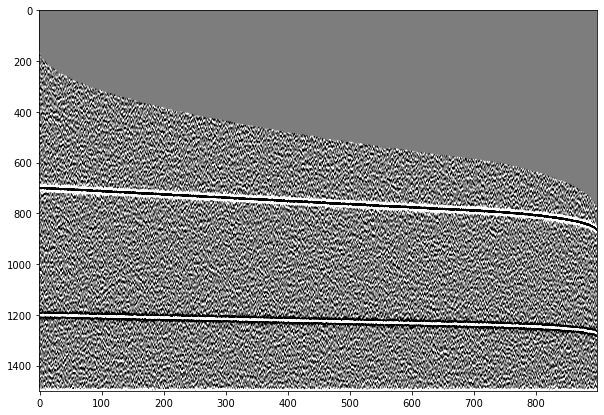

In [33]:
gather_muted.mute(muter)
gather_muted.plot()

Plot the seismogram before muting for comparison.

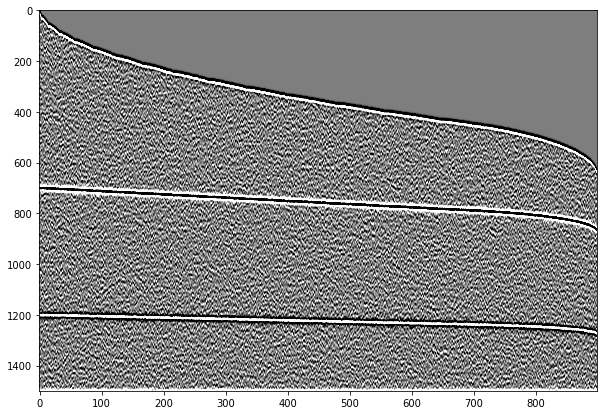

In [34]:
gather.plot()

### Conclusion

This tutorial:
- explained the purpose of the `Gather` class and ways to create one.
- listed `Gather`'s attributes and their contents.
- showed `Gather`'s processing methods and how they affect the data.

[Go to top](#Gather-Tutorial)